In [1]:

import numpy as np
from scipy.optimize import milp, LinearConstraint, Bounds, OptimizeResult
from typing import List

import matplotlib.pyplot as plt

def mle_decoder(M : int, 
                I : List[List[int]],
                C : List[int],
                p : List[float] | float) -> OptimizeResult:
    """
    Solves the MLE decoder problem using a MILP solver.

    Parameters:
        - M: Number of binary variables E_j.
        - I: List of lists. I[i] is the set of errors E_j which flip the check C_i
        - C: Constraint values C_i.
        - p: List of probabilities p_j for each E_j.

    Returns:
        - result: The result object from scipy.optimize.milp.
        
    """
    # Validate input data
    N = len(I)
    assert len(C) == N, "Length of C must be N"

    if np.isscalar(p):
        p = [p] * M
    elif type(p) is List:
        assert len(p) == M, "Length of p must be M"
    else:
        raise ValueError('p must be a float or a list of floats')

    # Idea: The decision variable x contains both E_j and K_i values.
    # i.e. x = [E_1, ..., E_M, K_1, ..., K_N]
    # The scipy milp solver minimizes <c, x> where c is the objective function coefficients. 
    # We can ignore the constant log(1-p_j) in the objective function.

    # Construct the objective function coefficients, by default set the K_i coefficients to zero
    # Note the minus sign for the E_i coeffs because the solver minimizes the objective function
    c = np.array([-np.log(p_j) + np.log(1 - p_j) for p_j in p] + [0]*N) 

    # Construct equality constraints matrix (constraints are Ax = b)
    A_eq = np.zeros((N, M + N)) # N constraints, (M + N) variables
    b_eq = []
    for i in range(N):

        # Constraint for the check, C_i is: \sum_{Ej in I_i} E_j - 2K_i = (1 - C_i)/2
        # where I_i is the set of errors [...,E_j,...] that flip the check C_i
        
        # Firstly, set the matrix elements to pick out the appropriate E_j values
        for j in I[i]:
            if j >= M:
                raise ValueError(f"E_j index {j} exceeds M-1")
            A_eq[i, j] = 1

        # Next, set matrix elements to pick out the corresponding K_i
        A_eq[i, M + i] = -2

        # Lastly, compute the right-hand side (1 - C_i)/2
        b_eq.append((1 - C[i]) / 2)

    # Define constraints (equality constraints)
    constraints = LinearConstraint(A=A_eq, lb=b_eq, ub=b_eq)

    # Bounds: E_j: binary (0-1), K_i: integer >=0
    bounds = Bounds(lb = [0]*M + [0]*N,
                    ub = [1]*M + [np.inf]*N)

    # Integrality: Both E_j and K_i are integers within bounds (i.e. 1)
    integrality = [1]*(M + N)  

    # Solve the MILP
    res = milp(c           = c,
               constraints = constraints,
               integrality = integrality,
               bounds      = bounds)
    
    return M, N, res

def print_result(M,N,result):
    if result.success:
        print("Optimization successful.")
        print(">> Maximum objective value:", -result.fun)  # Convert back to maximization
        print(">> Optimal E_j values:")
        for j in range(M):
            print(f"\t E_{j+1} = {round(result.x[j])}")
        print(">> Optimal K_i values:")
        for i in range(N):
            print(f"\t K_{i+1} = {int(result.x[M + i])}")
    else:
        print("No optimal solution found.")
        print("Status:", result.message)
        print("Details:", result.get("message", "No additional information"))


In [2]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [1]:
from baconshor import *

## Repetition code

List of errors: $$\{ E_j \}_{j=1}^M = \{ X_0, X_1, \dots, X_{M-1} \} \implies M = 3$$
Syndrome values: $$\{ C_i \} = \{ Z_0 Z_1, Z_1 Z_2, \dots, Z_{M-2} Z_{M-1} \}$$
Errors detected by each syndrome:
$$ I(C_0 = Z_0 Z_1) = \{ X_0, X_1 \}$$
$$ I(C_1 = Z_1 Z_2) = \{ X_1, X_2 \}$$
$$ \vdots $$
$$ I(C_{M-2} = Z_{M-2} Z_{M-1}) = \{ X_{M-2}, X_{M-1} \}$$

In [ ]:
# Set up for the code
M = 3
I = [[j,j+1] for j in range(M-1)]

# Particular syndrome measurement
C = [-1,1] 
p = 0.4

expected_E = [1,0,0]
print('Expected E_j values')
for j in range(M):
    print(f'\t E_{j} = {expected_E[j]}')
print()

print_result(*mle_decoder(M,I,C,p))

Expected E_j values
	 E_0 = 1
	 E_1 = 0
	 E_2 = 0

Optimization successful.
>> Maximum objective value: -0.4054651081081643
>> Optimal E_j values:
	 E_1 = 1
	 E_2 = 0
	 E_3 = 0
>> Optimal K_i values:
	 K_1 = 0
	 K_2 = 0


In [ ]:
# Set up for the code
M = 5
I = [[j,j+1] for j in range(M-1)]

# Particular syndrome measurement
C = [-1,1,-1,1] 
p = 0.4

expected_E = [0,1,1,0,0]
print('Expected E_j values')
for j in range(M):
    print(f'\t E_{j} = {expected_E[j]}')
print()

print_result(*mle_decoder(M,I,C,p))

Expected E_j values
	 E_0 = 0
	 E_1 = 1
	 E_2 = 1
	 E_3 = 0
	 E_4 = 0

Optimization successful.
>> Maximum objective value: -0.8109302162163285
>> Optimal E_j values:
	 E_1 = 0
	 E_2 = 1
	 E_3 = 1
	 E_4 = 0
	 E_5 = 0
>> Optimal K_i values:
	 K_1 = 0
	 K_2 = 1
	 K_3 = 0
	 K_4 = 0


## Bacon Shor

In [2]:

import numpy as np
from scipy.optimize import milp, LinearConstraint, Bounds, OptimizeResult
from typing import List
import matplotlib.pyplot as plt
import csv
def mle_decoder_bs(M : int, 
                I : List[List[int]],
                C : List[int],
                p : List[float] | float) -> OptimizeResult:
    """
    Solves the MLE decoder problem using a MILP solver.

    Parameters:
        - M: Number of binary variables E_j.
        - I: List of lists. I[i] is the set of errors E_j which flip the check C_i
        - C: Constraint values C_i.
        - p: List of probabilities p_j for each E_j.

    Returns:
        - result: The result object from scipy.optimize.milp.
        
    """
    # Validate input data
    N = len(I)
    assert len(C) == N, "Length of C must be N"

    if np.isscalar(p):
        p = [p] * M
    elif type(p) is List:
        assert len(p) == M, "Length of p must be M"
    else:
        raise ValueError('p must be a float or a list of floats')

    # Idea: The decision variable x contains both E_j and K_i values.
    # i.e. x = [E_1, ..., E_M, K_1, ..., K_N]
    # The scipy milp solver minimizes <c, x> where c is the objective function coefficients. 
    # We can ignore the constant log(1-p_j) in the objective function.

    # Construct the objective function coefficients, by default set the K_i coefficients to zero
    # Note the minus sign for the E_i coeffs because the solver minimizes the objective function
    c = np.array([-np.log(p_j) + np.log(1 - p_j) for p_j in p] + [0]*N) 

    # Construct equality constraints matrix (constraints are Ax = b)
    A_eq = np.zeros((N, M + N)) # N constraints, (M + N) variables
    b_eq = []
    for i in range(N):

        # Constraint for the check, C_i is: \sum_{Ej in I_i} E_j - 2K_i = (1 - C_i)/2
        # where I_i is the set of errors [...,E_j,...] that flip the check C_i
        
        # Firstly, set the matrix elements to pick out the appropriate E_j values
        for j in I[i]:
            if j >= M:
                raise ValueError(f"E_j index {j} exceeds M-1")
            A_eq[i, j] = 1

        # Next, set matrix elements to pick out the corresponding K_i
        A_eq[i, M + i] = -2

        # Lastly, compute the right-hand side (1 - C_i)/2
        b_eq.append((1 - C[i]) / 2)

    # Define constraints (equality constraints)
    constraints = LinearConstraint(A=A_eq, lb=b_eq, ub=b_eq)

    # Bounds: E_j: binary (0-1), K_i: integer >=0
    bounds = Bounds(lb = [0]*M + [0]*N,
                    ub = [1]*M + [np.inf]*N)

    # Integrality: Both E_j and K_i are integers within bounds (i.e. 1)
    integrality = [1]*(M + N)  

    # Solve the MILP
    res = milp(c           = c,
               constraints = constraints,
               integrality = integrality,
               bounds      = bounds)
    
    return M, N, res

def Print_result(M,N,result):
    guess = []
    if result.success:
        print("Optimization successful.")
        print(">> Maximum objective value:", -result.fun)  # Convert back to maximization
        print(">> Optimal E_j values:")
        for j in range(M):
            print(f"\t E_{j+1} = {round(result.x[j])}")
            guess.append(round(result.x[j]))
        print(">> Optimal K_i values:")
        for i in range(N):
            print(f"\t K_{i+1} = {int(result.x[M + i])}")
    else:
        print("No optimal solution found.")
        print("Status:", result.message)
        print("Details:", result.get("message", "No additional information"))

    return guess

def print_result(M,N,result):
    guess = []
    if result.success:
        # print("Optimization successful.")
        # print(">> Maximum objective value:", -result.fun)  # Convert back to maximization
        # print(">> Optimal E_j values:")
        for j in range(M):
            # print(f"\t E_{j+1} = {round(result.x[j])}")
            guess.append(round(result.x[j]))
        # print(">> Optimal K_i values:")
        # for i in range(N):
        #     print(f"\t K_{i+1} = {int(result.x[M + i])}")
    else:
        print("No optimal solution found.")
        # print("Status:", result.message)
        # print("Details:", result.get("message", "No additional information"))

    return guess

In [6]:
# Set up for the code
M = 3
grid = create_grid(3)# no error
I, C = construct_stabilizers_scipy(M,grid)

# Particular syndrome measurement
p = 0.4

# expected_E = [1,0,0]
# print('Expected E_j values')
# for j in range(M):
#     print(f'\t E_{j} = {expected_E[j]}')
# print()

guess = print_result(*mle_decoder_bs(M**2,I,C,p))

In [7]:
# Set up for the code
M = 3
grid = create_grid(3)# no error
add_y_error(grid,[3])
Print(grid)
I, C = construct_stabilizers_scipy(M,grid)

# Particular syndrome measurement
p = 0.4

# expected_E = [1,0,0]
# print('Expected E_j values')
# for j in range(M):
#     print(f'\t E_{j} = {expected_E[j]}')
# print()

guess = print_result(*mle_decoder_bs(M**2,I,C,p))
solver_accuracy(3,grid,solver_to_grid_scipy(M,guess))

0 0 1 
0 0 0 
0 0 0 


True

In [8]:
Print(solver_to_grid_scipy(3,guess))


0 0 1 
0 0 0 
0 0 0 


In [9]:
# Set up for the code
M = 5
grid = create_grid(5)# no error
add_y_error(grid,[5,6,14,17])
Print(grid)
I, C = construct_stabilizers_scipy(M,grid)

# Particular syndrome measurement
p = 0.4

# expected_E = [1,0,0]
# print('Expected E_j values')
# for j in range(M):
#     print(f'\t E_{j} = {expected_E[j]}')
# print()

guess = print_result(*mle_decoder_bs(M**2,I,C,p))
solver_accuracy(M,grid,solver_to_grid_scipy(M,guess))

0 0 0 0 1 
1 0 0 0 0 
0 0 0 1 0 
0 1 0 0 0 
0 0 0 0 0 


False

In [10]:
M=3
physical_error_probs = np.linspace(0.01, 0.70, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(1024):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/1024)
phys_three = physical_error_probs
log_three = logical_error_probs

/vast/palmer/home.grace/sj837/BiasedBaconShor/baconshor.py:328: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=6)


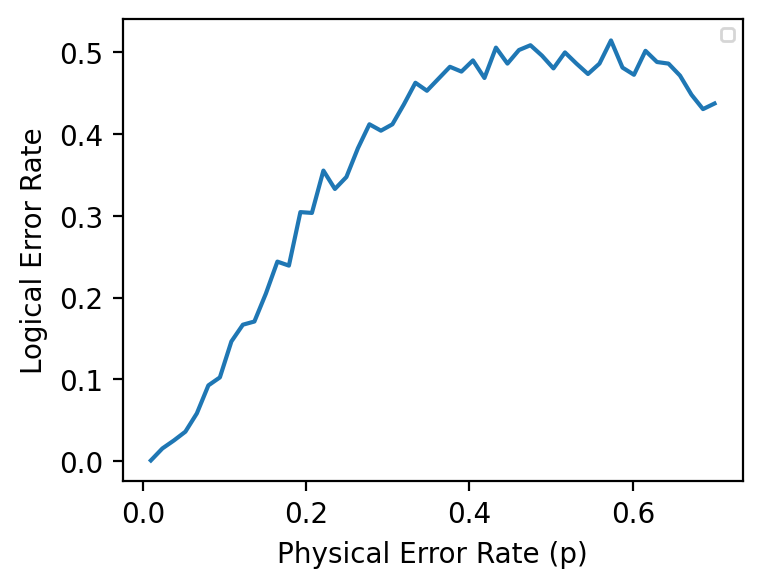

In [11]:
plot(phys_three, log_three)

In [12]:
M=5
physical_error_probs = np.linspace(0.01, 0.70, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(1024):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/1024)
phys_five = physical_error_probs
log_five = logical_error_probs

/vast/palmer/home.grace/sj837/BiasedBaconShor/baconshor.py:328: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=6)


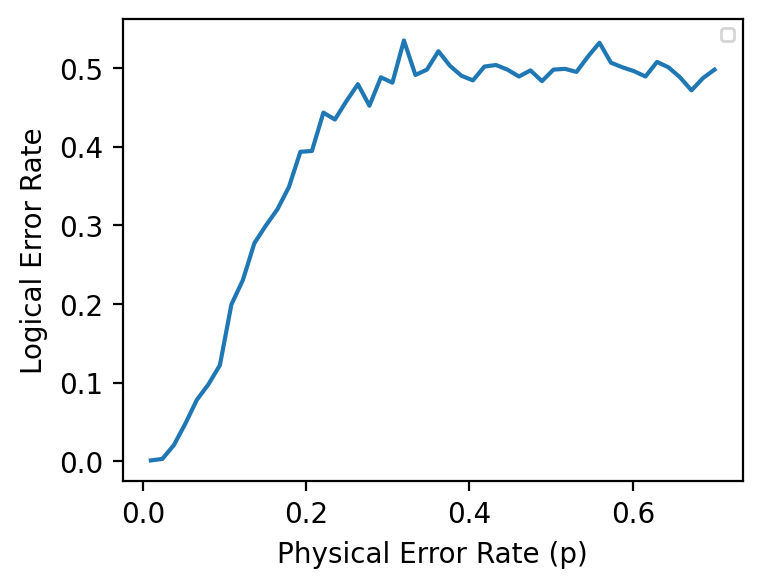

In [13]:
plot(phys_five, log_five)

In [28]:
# Set up for the code
M = 7
grid = create_grid(7)# no error
add_y_error(grid,[7,8,10,11,14,36,3,27,28,30,31,2,4])
Print(grid)
I, C = construct_stabilizers_scipy(M,grid)

# Particular syndrome measurement
p = 0.7

# expected_E = [1,0,0]
# print('Expected E_j values')
# for j in range(M):
#     print(f'\t E_{j} = {expected_E[j]}')
# print()

guess = print_result(*mle_decoder_bs(M**2,I,C,p))
solver_accuracy(M,grid,solver_to_grid_scipy(M,guess))

0 1 1 1 0 0 1 
1 0 1 1 0 0 1 
0 0 0 0 0 0 0 
0 0 0 0 0 1 1 
0 1 1 0 0 0 0 
1 0 0 0 0 0 0 
0 0 0 0 0 0 0 


False

In [14]:
M=7
physical_error_probs = np.linspace(0.01, 0.70, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(1024):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/1024)
phys_seven = physical_error_probs
log_seven = logical_error_probs

/vast/palmer/home.grace/sj837/BiasedBaconShor/baconshor.py:328: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=6)


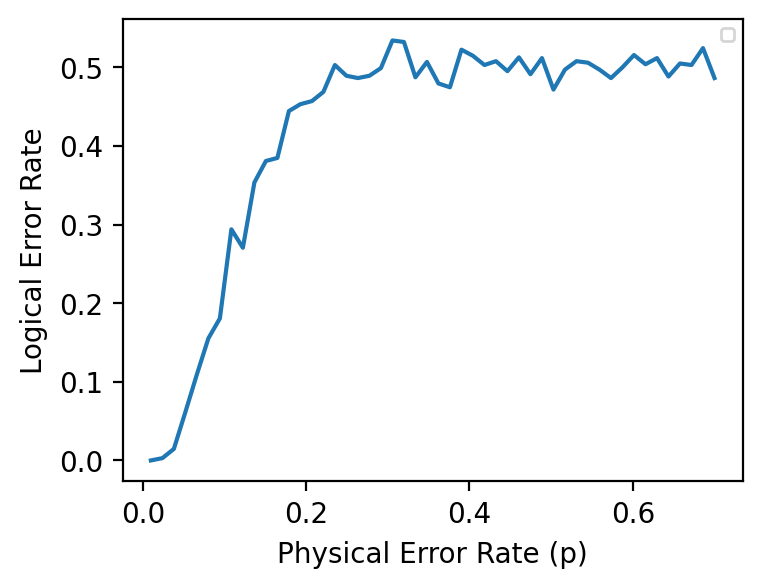

In [15]:
plot(phys_seven, log_seven)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


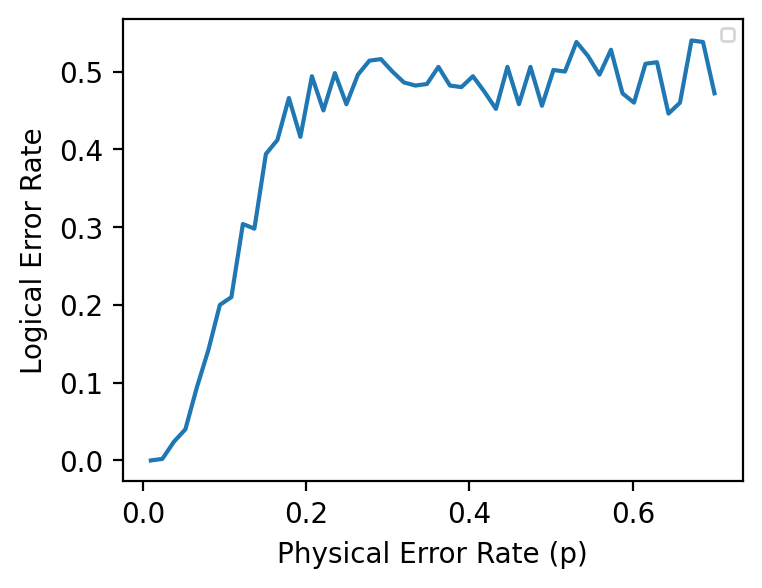

In [35]:
plot(phys_seven, log_seven)

/tmp/ipykernel_3502208/3920636277.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=6)


[]

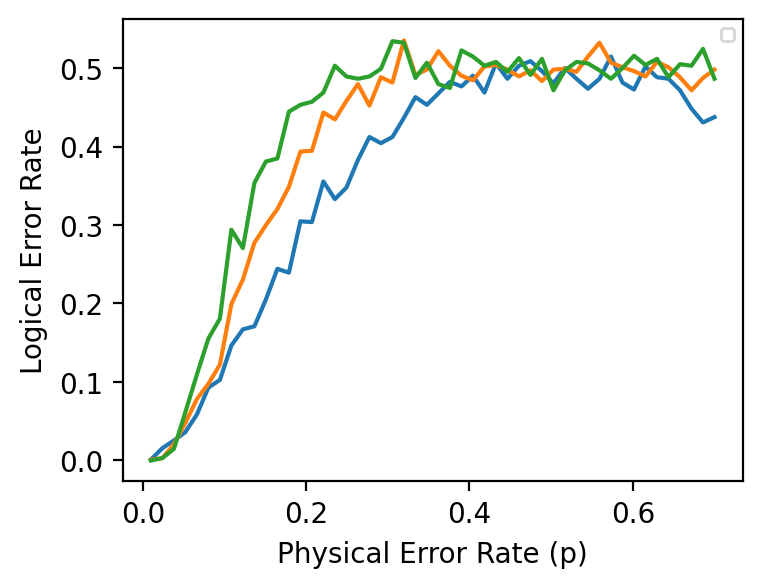

In [16]:
all_logical_error_probs = [log_three, log_five, log_seven]
fig,ax = plt.subplots(1,1,dpi=200,figsize = (4,3))
for log in all_logical_error_probs:
    ax.plot(phys_three,log)
ax.legend(fontsize=6)
ax.set_xlabel("Physical Error Rate (p)")
ax.set_ylabel("Logical Error Rate")
plt.plot()


/tmp/ipykernel_3502208/1119582500.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=6)


[]

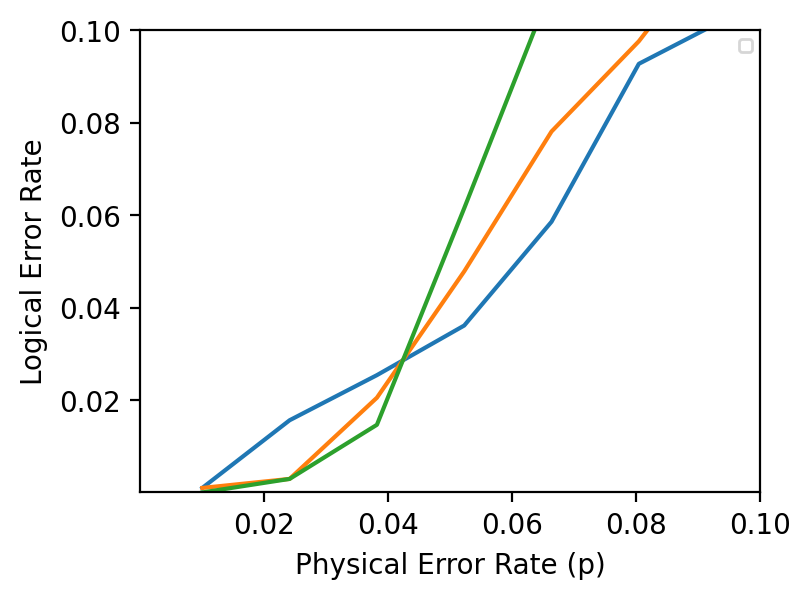

In [17]:
all_logical_error_probs = [log_three, log_five, log_seven]
fig,ax = plt.subplots(1,1,dpi=200,figsize = (4,3))
for log in all_logical_error_probs:
    ax.plot(phys_three,log)
ax.legend(fontsize=6)
ax.set_xlabel("Physical Error Rate (p)")
ax.set_ylabel("Logical Error Rate")
ax.set_ylim(1e-6, 0.1)
ax.set_xlim(1e-6, 0.1)
plt.plot()

In [7]:
M=3
physical_error_probs = np.linspace(0.01, 0.70, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(1024):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/1024)
phys_three = physical_error_probs
log_three = logical_error_probs
print(phys_three)
print(log_three)

[0.01       0.02408163 0.03816327 0.0522449  0.06632653 0.08040816
 0.0944898  0.10857143 0.12265306 0.13673469 0.15081633 0.16489796
 0.17897959 0.19306122 0.20714286 0.22122449 0.23530612 0.24938776
 0.26346939 0.27755102 0.29163265 0.30571429 0.31979592 0.33387755
 0.34795918 0.36204082 0.37612245 0.39020408 0.40428571 0.41836735
 0.43244898 0.44653061 0.46061224 0.47469388 0.48877551 0.50285714
 0.51693878 0.53102041 0.54510204 0.55918367 0.57326531 0.58734694
 0.60142857 0.6155102  0.62959184 0.64367347 0.6577551  0.67183673
 0.68591837 0.7       ]
[0.0029296875, 0.00390625, 0.0263671875, 0.0439453125, 0.0634765625, 0.076171875, 0.12109375, 0.1533203125, 0.1591796875, 0.1923828125, 0.1865234375, 0.2490234375, 0.259765625, 0.271484375, 0.333984375, 0.314453125, 0.326171875, 0.3818359375, 0.380859375, 0.4208984375, 0.41015625, 0.4521484375, 0.453125, 0.44140625, 0.4794921875, 0.4560546875, 0.45703125, 0.478515625, 0.4794921875, 0.498046875, 0.521484375, 0.52734375, 0.4853515625, 0.4

In [8]:
M=5
physical_error_probs = np.linspace(0.01, 0.70, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(1024):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/1024)
phys_five = physical_error_probs
log_five = logical_error_probs
print(phys_five)
print(log_five)

[0.01       0.02408163 0.03816327 0.0522449  0.06632653 0.08040816
 0.0944898  0.10857143 0.12265306 0.13673469 0.15081633 0.16489796
 0.17897959 0.19306122 0.20714286 0.22122449 0.23530612 0.24938776
 0.26346939 0.27755102 0.29163265 0.30571429 0.31979592 0.33387755
 0.34795918 0.36204082 0.37612245 0.39020408 0.40428571 0.41836735
 0.43244898 0.44653061 0.46061224 0.47469388 0.48877551 0.50285714
 0.51693878 0.53102041 0.54510204 0.55918367 0.57326531 0.58734694
 0.60142857 0.6155102  0.62959184 0.64367347 0.6577551  0.67183673
 0.68591837 0.7       ]
[0.0, 0.0048828125, 0.013671875, 0.0419921875, 0.0712890625, 0.1015625, 0.158203125, 0.1875, 0.212890625, 0.263671875, 0.2880859375, 0.33984375, 0.359375, 0.373046875, 0.384765625, 0.3994140625, 0.46875, 0.439453125, 0.4931640625, 0.486328125, 0.482421875, 0.478515625, 0.5029296875, 0.484375, 0.525390625, 0.4990234375, 0.5048828125, 0.5, 0.5029296875, 0.5009765625, 0.498046875, 0.5, 0.4990234375, 0.5048828125, 0.46875, 0.4990234375, 0.5

In [9]:
M=7
physical_error_probs = np.linspace(0.01, 0.70, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(1024):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/1024)
phys_seven = physical_error_probs
log_seven = logical_error_probs
print(phys_seven)
print(log_seven)

[0.01       0.02408163 0.03816327 0.0522449  0.06632653 0.08040816
 0.0944898  0.10857143 0.12265306 0.13673469 0.15081633 0.16489796
 0.17897959 0.19306122 0.20714286 0.22122449 0.23530612 0.24938776
 0.26346939 0.27755102 0.29163265 0.30571429 0.31979592 0.33387755
 0.34795918 0.36204082 0.37612245 0.39020408 0.40428571 0.41836735
 0.43244898 0.44653061 0.46061224 0.47469388 0.48877551 0.50285714
 0.51693878 0.53102041 0.54510204 0.55918367 0.57326531 0.58734694
 0.60142857 0.6155102  0.62959184 0.64367347 0.6577551  0.67183673
 0.68591837 0.7       ]
[0.0, 0.005859375, 0.0166015625, 0.0517578125, 0.09375, 0.1376953125, 0.2138671875, 0.2529296875, 0.3017578125, 0.33984375, 0.4033203125, 0.396484375, 0.412109375, 0.453125, 0.5009765625, 0.470703125, 0.5029296875, 0.49609375, 0.478515625, 0.50390625, 0.517578125, 0.486328125, 0.4990234375, 0.486328125, 0.4931640625, 0.498046875, 0.4794921875, 0.5205078125, 0.48828125, 0.484375, 0.5205078125, 0.5224609375, 0.509765625, 0.5078125, 0.4833

In [4]:
M=9
physical_error_probs = np.linspace(0.01, 0.70, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(500):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/500)
phys_nine = physical_error_probs
log_nine = logical_error_probs
print(phys_nine)
print(log_nine)

[0.01       0.02408163 0.03816327 0.0522449  0.06632653 0.08040816
 0.0944898  0.10857143 0.12265306 0.13673469 0.15081633 0.16489796
 0.17897959 0.19306122 0.20714286 0.22122449 0.23530612 0.24938776
 0.26346939 0.27755102 0.29163265 0.30571429 0.31979592 0.33387755
 0.34795918 0.36204082 0.37612245 0.39020408 0.40428571 0.41836735
 0.43244898 0.44653061 0.46061224 0.47469388 0.48877551 0.50285714
 0.51693878 0.53102041 0.54510204 0.55918367 0.57326531 0.58734694
 0.60142857 0.6155102  0.62959184 0.64367347 0.6577551  0.67183673
 0.68591837 0.7       ]
[0.0, 0.002, 0.024, 0.096, 0.11, 0.212, 0.23, 0.306, 0.376, 0.396, 0.418, 0.426, 0.472, 0.48, 0.466, 0.474, 0.494, 0.5, 0.498, 0.488, 0.492, 0.488, 0.514, 0.51, 0.516, 0.498, 0.518, 0.484, 0.532, 0.496, 0.492, 0.508, 0.496, 0.498, 0.504, 0.506, 0.472, 0.504, 0.49, 0.546, 0.504, 0.5, 0.51, 0.534, 0.534, 0.482, 0.482, 0.488, 0.492, 0.502]


/vast/palmer/home.grace/sj837/BiasedBaconShor/baconshor.py:328: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=6)


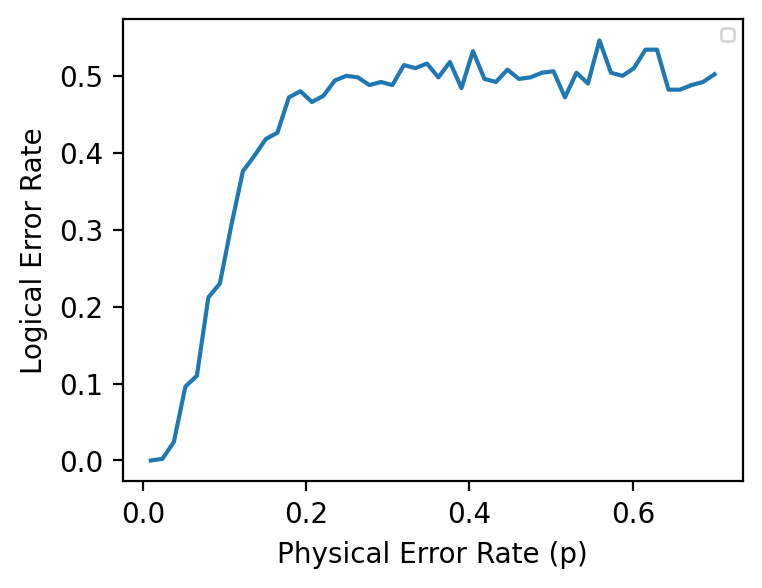

In [5]:
plot(phys_nine, log_nine)

/tmp/ipykernel_3572510/2907467376.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=6)


[]

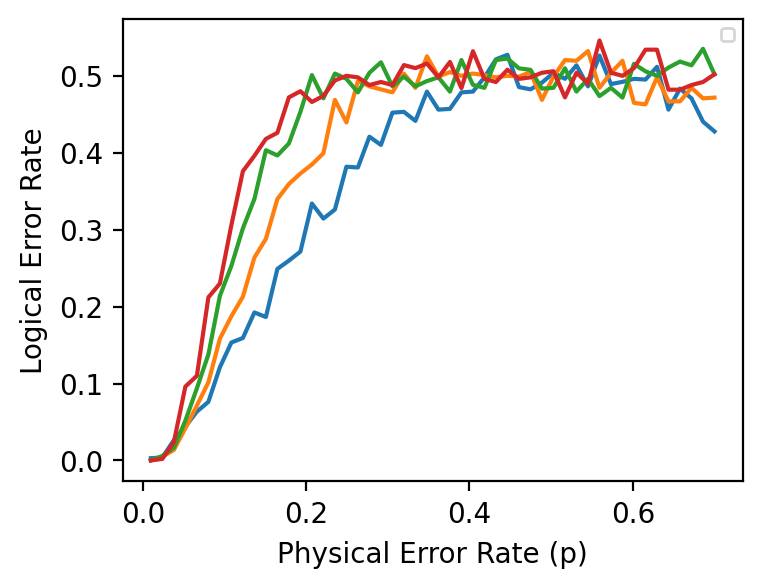

In [7]:
log_three = [0.0029296875, 0.00390625, 0.0263671875, 0.0439453125, 0.0634765625, 0.076171875, 0.12109375, 0.1533203125, 0.1591796875, 0.1923828125, 0.1865234375, 0.2490234375, 0.259765625, 0.271484375, 0.333984375, 0.314453125, 0.326171875, 0.3818359375, 0.380859375, 0.4208984375, 0.41015625, 0.4521484375, 0.453125, 0.44140625, 0.4794921875, 0.4560546875, 0.45703125, 0.478515625, 0.4794921875, 0.498046875, 0.521484375, 0.52734375, 0.4853515625, 0.482421875, 0.4912109375, 0.50390625, 0.49609375, 0.513671875, 0.486328125, 0.5263671875, 0.4892578125, 0.4921875, 0.49609375, 0.4951171875, 0.51171875, 0.4560546875, 0.4833984375, 0.470703125, 0.4404296875, 0.427734375]
log_five = [0.0, 0.0048828125, 0.013671875, 0.0419921875, 0.0712890625, 0.1015625, 0.158203125, 0.1875, 0.212890625, 0.263671875, 0.2880859375, 0.33984375, 0.359375, 0.373046875, 0.384765625, 0.3994140625, 0.46875, 0.439453125, 0.4931640625, 0.486328125, 0.482421875, 0.478515625, 0.5029296875, 0.484375, 0.525390625, 0.4990234375, 0.5048828125, 0.5, 0.5029296875, 0.5009765625, 0.498046875, 0.5, 0.4990234375, 0.5048828125, 0.46875, 0.4990234375, 0.5205078125, 0.51953125, 0.5322265625, 0.484375, 0.50390625, 0.51953125, 0.46484375, 0.462890625, 0.498046875, 0.466796875, 0.466796875, 0.484375, 0.470703125, 0.4716796875]
log_seven = [0.0, 0.005859375, 0.0166015625, 0.0517578125, 0.09375, 0.1376953125, 0.2138671875, 0.2529296875, 0.3017578125, 0.33984375, 0.4033203125, 0.396484375, 0.412109375, 0.453125, 0.5009765625, 0.470703125, 0.5029296875, 0.49609375, 0.478515625, 0.50390625, 0.517578125, 0.486328125, 0.4990234375, 0.486328125, 0.4931640625, 0.498046875, 0.4794921875, 0.5205078125, 0.48828125, 0.484375, 0.5205078125, 0.5224609375, 0.509765625, 0.5078125, 0.4833984375, 0.484375, 0.509765625, 0.4794921875, 0.49609375, 0.4736328125, 0.484375, 0.4716796875, 0.515625, 0.505859375, 0.5, 0.5107421875, 0.5185546875, 0.513671875, 0.53515625, 0.501953125]
all_logical_error_probs = [log_three, log_five, log_seven, log_nine]
fig,ax = plt.subplots(1,1,dpi=200,figsize = (4,3))
for log in all_logical_error_probs:
    ax.plot(phys_nine,log)
ax.legend(fontsize=6)
ax.set_xlabel("Physical Error Rate (p)")
ax.set_ylabel("Logical Error Rate")
plt.plot()

/tmp/ipykernel_3572510/1358424781.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=6)


[]

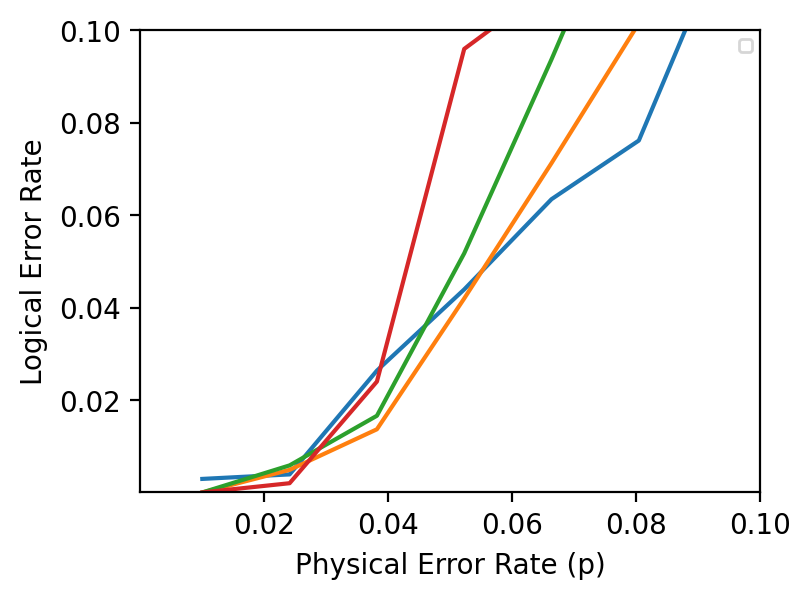

In [9]:
all_logical_error_probs = [log_three, log_five, log_seven, log_nine]
fig,ax = plt.subplots(1,1,dpi=200,figsize = (4,3))
for log in all_logical_error_probs:
    ax.plot(phys_nine,log)
ax.legend(fontsize=6)
ax.set_xlabel("Physical Error Rate (p)")
ax.set_ylabel("Logical Error Rate")
ax.set_ylim(1e-6, 0.1)
ax.set_xlim(1e-6, 0.1)
plt.plot()

# Updated Graphs for different weights with Scipy decoder

In [3]:
M=3
shots = 2000
physical_error_probs = np.linspace(0.01, 0.2, num=50)#physical error probs
logical_error_probs=[]
error_bars_three = []
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(shots):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    log_error_prob = count/shots
    std = np.sqrt(log_error_prob * (1 - log_error_prob) / shots)
    logical_error_probs.append(log_error_prob)
    error_bars_three.append(std)

phys_three = physical_error_probs
log_three = logical_error_probs
print(phys_three)
print(log_three)

[0.01       0.01387755 0.0177551  0.02163265 0.0255102  0.02938776
 0.03326531 0.03714286 0.04102041 0.04489796 0.04877551 0.05265306
 0.05653061 0.06040816 0.06428571 0.06816327 0.07204082 0.07591837
 0.07979592 0.08367347 0.08755102 0.09142857 0.09530612 0.09918367
 0.10306122 0.10693878 0.11081633 0.11469388 0.11857143 0.12244898
 0.12632653 0.13020408 0.13408163 0.13795918 0.14183673 0.14571429
 0.14959184 0.15346939 0.15734694 0.16122449 0.16510204 0.16897959
 0.17285714 0.17673469 0.18061224 0.1844898  0.18836735 0.1922449
 0.19612245 0.2       ]
[0.0025, 0.002, 0.008, 0.01, 0.0085, 0.013, 0.018, 0.02, 0.03, 0.036, 0.035, 0.0375, 0.037, 0.049, 0.05, 0.0625, 0.069, 0.0735, 0.088, 0.094, 0.0895, 0.114, 0.1175, 0.1175, 0.126, 0.1325, 0.131, 0.1245, 0.149, 0.1525, 0.171, 0.1715, 0.1855, 0.176, 0.1915, 0.195, 0.1995, 0.2275, 0.233, 0.22, 0.2435, 0.238, 0.2605, 0.259, 0.269, 0.2505, 0.2895, 0.2875, 0.2735, 0.297]


In [6]:
M=5
shots = 2000
physical_error_probs = np.linspace(0.01, 0.2, num=50)#physical error probs
logical_error_probs=[]
error_bars_five = []
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(shots):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    log_error_prob = count/shots
    std = np.sqrt(log_error_prob * (1 - log_error_prob) / shots)
    logical_error_probs.append(log_error_prob)
    error_bars_five.append(std)

phys_five = physical_error_probs
log_five = logical_error_probs
print(phys_five)
print(log_five)

[0.01       0.01387755 0.0177551  0.02163265 0.0255102  0.02938776
 0.03326531 0.03714286 0.04102041 0.04489796 0.04877551 0.05265306
 0.05653061 0.06040816 0.06428571 0.06816327 0.07204082 0.07591837
 0.07979592 0.08367347 0.08755102 0.09142857 0.09530612 0.09918367
 0.10306122 0.10693878 0.11081633 0.11469388 0.11857143 0.12244898
 0.12632653 0.13020408 0.13408163 0.13795918 0.14183673 0.14571429
 0.14959184 0.15346939 0.15734694 0.16122449 0.16510204 0.16897959
 0.17285714 0.17673469 0.18061224 0.1844898  0.18836735 0.1922449
 0.19612245 0.2       ]
[0.0005, 0.0015, 0.0045, 0.007, 0.006, 0.0095, 0.0105, 0.0165, 0.0145, 0.0295, 0.026, 0.0415, 0.0445, 0.0735, 0.074, 0.0765, 0.0935, 0.1065, 0.12, 0.116, 0.125, 0.132, 0.147, 0.158, 0.176, 0.177, 0.1985, 0.1935, 0.213, 0.216, 0.2265, 0.262, 0.25, 0.27, 0.3085, 0.3015, 0.3, 0.3055, 0.3175, 0.3365, 0.3415, 0.333, 0.372, 0.366, 0.37, 0.3725, 0.3955, 0.378, 0.412, 0.3935]


In [ ]:
M=7
shots = 2000
physical_error_probs = np.linspace(0.01, 0.2, num=50)#physical error probs
logical_error_probs=[]
error_bars_seven = []
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(shots):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    log_error_prob = count/shots
    std = np.sqrt(log_error_prob * (1 - log_error_prob) / shots)
    logical_error_probs.append(log_error_prob)
    error_bars_seven.append(std)

phys_seven = physical_error_probs
log_seven = logical_error_probs
print(phys_seven)
print(log_seven)

In [ ]:
M=9
shots = 2000
physical_error_probs = np.linspace(0.01, 0.2, num=50)#physical error probs
logical_error_probs=[]
error_bars_nine = []
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(shots):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    log_error_prob = count/shots
    std = np.sqrt(log_error_prob * (1 - log_error_prob) / shots)
    logical_error_probs.append(log_error_prob)
    error_bars_nine.append(std)

phys_nine = physical_error_probs
log_nine = logical_error_probs
print(phys_nine)
print(log_nine)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


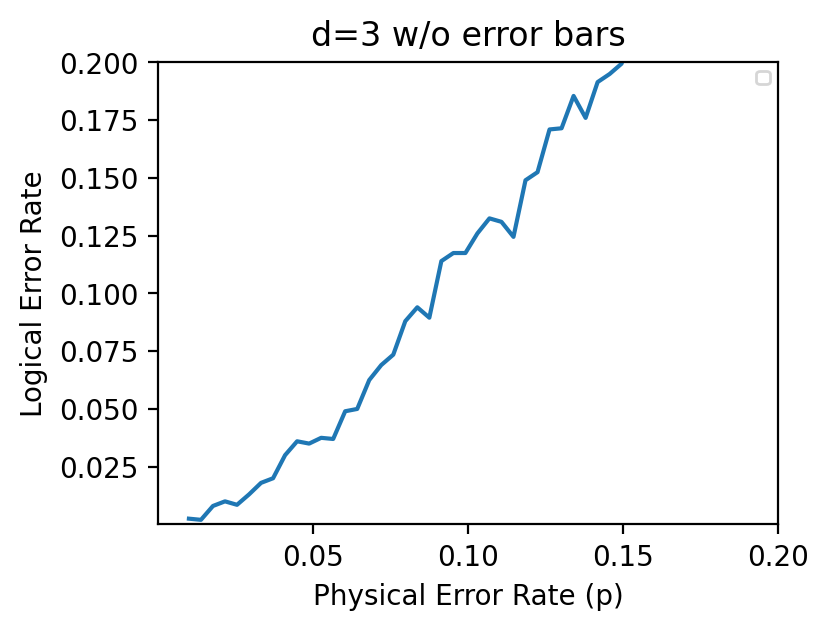

In [4]:
plot(phys_three, log_three,1e-6,0.2, "d=3 w/o error bars", None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


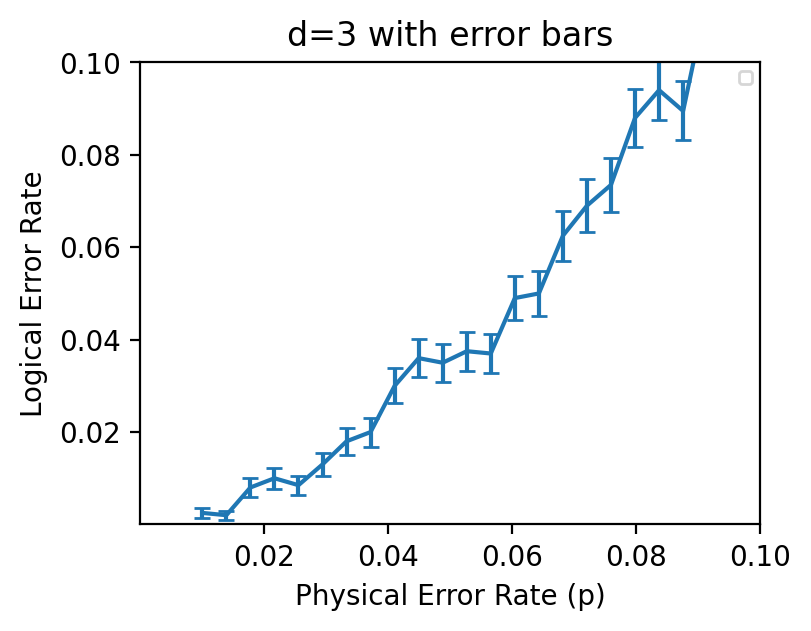

In [5]:
plot(phys_three, log_three, 1e-6,0.1, "d=3 with error bars", error_bars_three)

In [ ]:
plot(phys_five, log_five,1e-6,0.2, "d=5 w/o error bars", None)
plot(phys_five, log_five, 1e-6,0.1, "d=5 with error bars", error_bars_five)

plot(phys_seven, log_seven,1e-6,0.2, "d=7 w/o error bars", None)
plot(phys_seven, log_seven, 1e-6,0.1, "d=7 with error bars", error_bars_seven)

plot(phys_nine, log_nine,1e-6,0.2, "d=9 w/o error bars", None)
plot(phys_nine, log_nine, 1e-6,0.1, "d=9 with error bars", error_bars_nine)

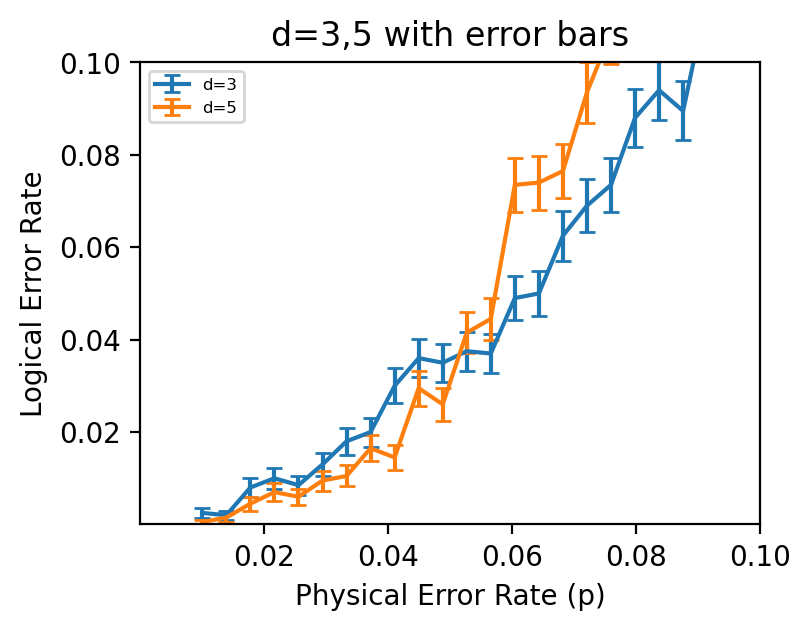

In [7]:
plot_multiple([3,5], phys_three, [log_three, log_five], 1e-6,0.1, "d=3,5 with error bars",[error_bars_three,error_bars_five])

In [ ]:
'''d=3,5,7,9, big, no error bars
d=3,5,7,9, small, no error bars
d=3,5,7,9, big, error bars
d=3,5,7,9, small, error bars
'''
plot_multiple([3,5,7,9], phys_three, [log_three, log_five,log_seven, log_nine], 1e-6,0.2, "d=3,5,7,9 w/o error bars")
plot_multiple([3,5,7,9], phys_three, [log_three, log_five,log_seven, log_nine], 1e-6,0.1, "d=3,5,7,9 w/o error bars")
plot_multiple([3,5,7,9], phys_three, [log_three, log_five,log_seven, log_nine], 1e-6,0.2, "d=3,5,7,9 w/ error bars", [error_bars_three, error_bars_five, error_bars_seven, error_bars_nine])
plot_multiple([3,5,7,9], phys_three, [log_three, log_five,log_seven, log_nine], 1e-6,0.1, "d=3,5,7,9 w/ error bars", [error_bars_three, error_bars_five, error_bars_seven, error_bars_nine])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

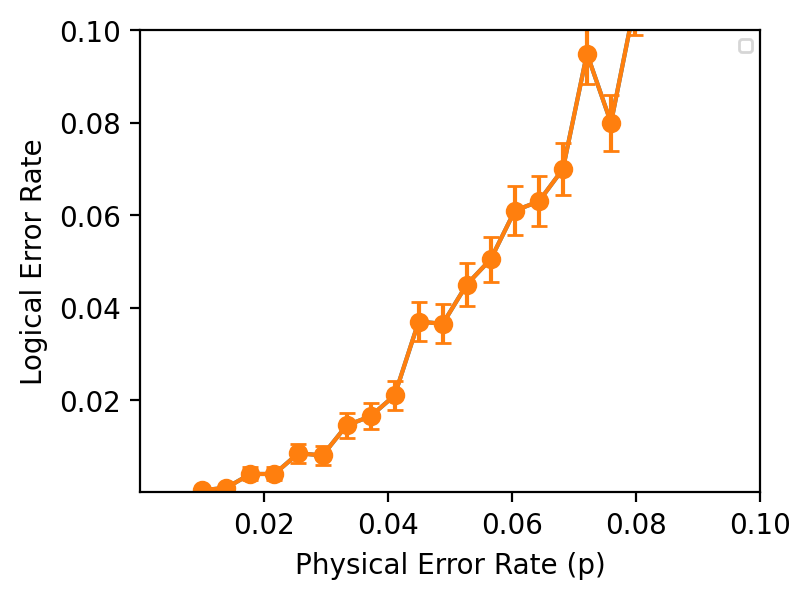

In [19]:
fig,ax = plt.subplots(1,1,dpi=200,figsize = (4,3))
ax.plot(phys_five,log_five)
ax.legend(fontsize=6)
plt.errorbar(phys_five, log_five, yerr=error_bars, fmt='o-', capsize=3)
ax.set_xlabel("Physical Error Rate (p)")
ax.set_ylabel("Logical Error Rate")
ax.set_ylim(1e-6, 0.1)
ax.set_xlim(1e-6, 0.1)
plt.plot()

In [ ]:


# data = [['Name', 'Age', 'City'],
#         ['Alice', 30, 'New York'],
#         ['Bob', 25, 'Los Angeles'],
#         ['Charlie', 35, 'Chicago']]

# filename = "output.csv"

# with open(filename, 'a', newline='') as csvfile:
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerows(data)